In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import NearMiss, TomekLinks, ClusterCentroids
from collections import Counter 


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import optuna
import torch.optim as optim

<h1><center>Preparing for training</center><h1>

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [30]:
# load ing the DS and label encoding
df = pd.read_csv('classification_cleaned.csv')
with open('class_names.pkl', 'rb') as f:
    class_names = pickle.load(f)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   alpha                90000 non-null  float64
 1   delta                90000 non-null  float64
 2   class                90000 non-null  int64  
 3   redshift             90000 non-null  float64
 4   photometric_filters  90000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 3.4 MB


In [32]:
# Blancing the class values 
X = df.drop('class', axis=1).values
y = df['class'].values
nm = NearMiss(version=2)
X, y = nm.fit_resample(X, y)
print("Resampled class distribution:", Counter(y))
# Source: https://imbalanced-learn.org/stable/under_sampling.html#controlled-under-sampling
# I used NearMiss 2 because it keeps Galaxy values that are far from the QSO
# Since Galaxy and QSO have close redshift values to each other, version 2 creates more distinct class boubndaries

Resampled class distribution: Counter({0: 13928, 1: 13928, 2: 13928})


In [33]:
# I am going to split the X and y before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Feature Scaling:
# Since ds is skewed, I am gonna use Robustscaler 
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print('Shape of training data:', X_train.shape, y_train.shape)
print('Shape of validation data:', X_val.shape, y_val.shape)
print('Shape of test data:', X_test.shape, y_test.shape)

Shape of training data: (29248, 4) (29248,)
Shape of validation data: (6268, 4) (6268,)
Shape of test data: (6268, 4) (6268,)


In [34]:
# Convertning numpy arrays to torch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Creating TensorDataset for each
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# Creating DataLoader for each dataset
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<h1><center>Defining the model class</center><h1>

In [35]:
class Multi_class(nn.Module):
  def __init__(self):
    super(Multi_class, self).__init__()
    
    # Layers
    self.fc1 = nn.Linear(X_train.shape[1], 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, 16)
    self.fc5 = nn.Linear(16, 3)

    # dropout layers
    self.dropout1 = nn.Dropout(0.2) 
  
  def forward(self, x):
    x = self.fc1(x); x = F.relu(x); x = self.dropout1(x)
    x = self.fc2(x); x = F.relu(x)
    x = self.fc3(x); x = F.relu(x)
    x = self.fc4(x); x = F.relu(x)
    x = self.fc5(x)
    return x

model = Multi_class().to(device)
print(model)
# I dont need to use softmax because CrossEntropyLoss does that internally

Multi_class(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
)


<h1><center>Training loop</center><h1>

In [36]:
# I am going to use CrossEntropyLoss for monitoring the loss, adam optimizer and ReduceLROnPlateau scheduler
criterion = nn.CrossEntropyLoss()            
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# If val loss does not improve for 5 epochs, lr is going to be cut by half
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [37]:
epochs = 150 
best_val_loss = float('inf')
early_stopping = 10
counter = 0
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'learning_rate': []}
# I used these variables to avoid overfitting and monitor training process

for epoch in range(1, epochs+1):
    model.train()  
    running_loss = 0.0
    
        # Batch processing
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        logits = model(batch_X)   
        # Loss calculation
        loss = criterion(logits, batch_y)     
        # Backward pass and optimization
        optimizer.zero_grad()   
        loss.backward()         
        optimizer.step()        
        
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

# EVALUATION
    model.eval() 
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():

        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            val_loss += loss.item()
            prediction = torch.argmax(logits, dim=1) 
            #c Counting correct predictions
            correct += (prediction == batch_y).sum().item()
            # Total number of samples for accuracy calculation later 
            total += batch_y.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total * 100.0
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])

    
    print(f"Epoch {epoch:02d}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%, Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    if avg_val_loss < best_val_loss:
        best_val_loss =  avg_val_loss
        counter = 0      
    else:
        counter += 1
        scheduler.step(avg_val_loss)
        if counter >= early_stopping:
            print("Early stopping")
            break

Epoch 01: Train Loss = 0.4294, Val Loss = 0.1773, Val Accuracy = 94.50%, Learning Rate: 0.001000
Epoch 02: Train Loss = 0.1813, Val Loss = 0.1401, Val Accuracy = 95.68%, Learning Rate: 0.001000
Epoch 03: Train Loss = 0.1552, Val Loss = 0.1288, Val Accuracy = 95.90%, Learning Rate: 0.001000
Epoch 04: Train Loss = 0.1399, Val Loss = 0.1216, Val Accuracy = 95.96%, Learning Rate: 0.001000
Epoch 05: Train Loss = 0.1309, Val Loss = 0.1146, Val Accuracy = 96.60%, Learning Rate: 0.001000
Epoch 06: Train Loss = 0.1218, Val Loss = 0.1100, Val Accuracy = 96.79%, Learning Rate: 0.001000
Epoch 07: Train Loss = 0.1200, Val Loss = 0.1081, Val Accuracy = 96.81%, Learning Rate: 0.001000
Epoch 08: Train Loss = 0.1135, Val Loss = 0.1041, Val Accuracy = 96.79%, Learning Rate: 0.001000
Epoch 09: Train Loss = 0.1084, Val Loss = 0.0996, Val Accuracy = 97.02%, Learning Rate: 0.001000
Epoch 10: Train Loss = 0.1057, Val Loss = 0.1108, Val Accuracy = 96.63%, Learning Rate: 0.001000
Epoch 11: Train Loss = 0.1009,

<h1><center>Evaluation</center><h1>

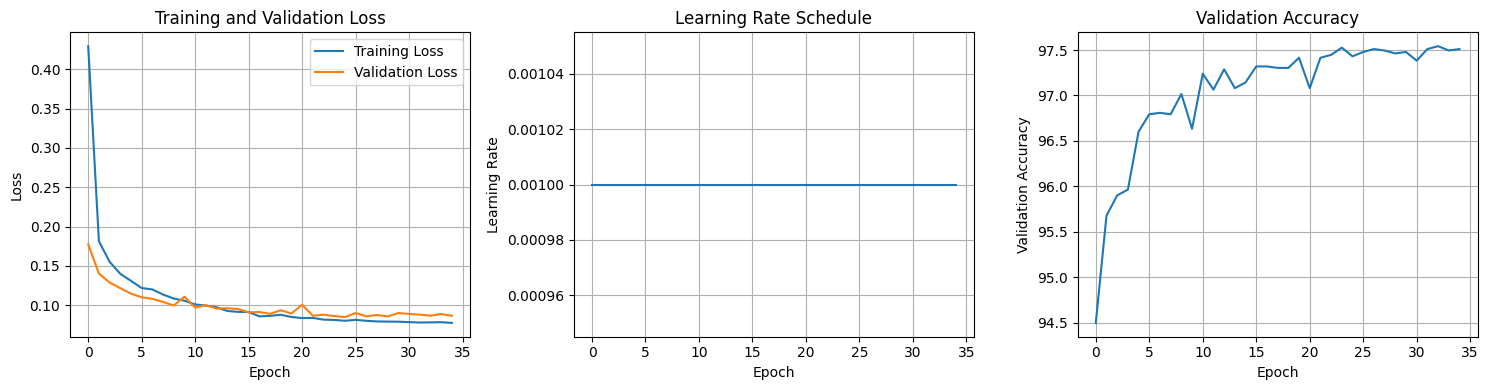

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Loss
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Learning rate
ax2.plot(history['learning_rate'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.grid(True)

# Validation Accuracy
ax3.plot(history['val_accuracy'])
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Validation Accuracy')
ax3.set_title('Validation Accuracy')
ax3.grid(True)

plt.tight_layout()
plt.show()
# What I can see from the graphs and training process is that the model covered well without overfitting
# The model got to 97 % accuracy on validation data which is great

In [52]:
# Testing the model on test data:
model.eval()
numbers_correct = 0
total = 0
predictions = []
correct_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)
        preds = torch.argmax(logits, dim=1)
        numbers_correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
        # Saving predictions and correct labels for confusion matrix
        predictions.extend(preds.tolist())
        correct_labels.extend(batch_y.tolist())

test_accuracy = numbers_correct / total * 100.0
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 97.81%


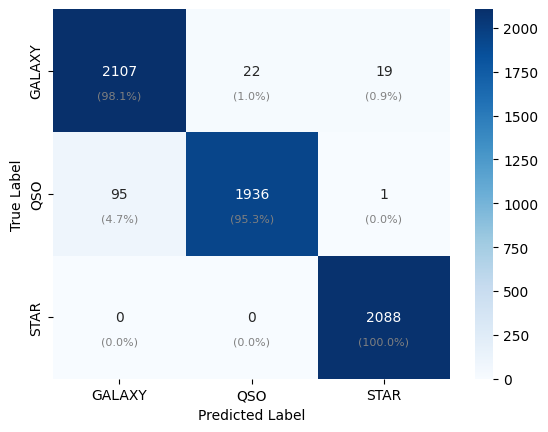

In [40]:
# Confusion Matrix 
Confusion_matrix = confusion_matrix(correct_labels, predictions)
# After getting the confusion matrix, I need to convert values to float and sum each row of matrix. for dividing each row by its total
# array must be 2D, so I use None to add new axis
Confusion_matrix_percent = Confusion_matrix.astype('float') / Confusion_matrix.sum(axis=1)[:, None] * 100
sns.heatmap(Confusion_matrix, fmt='d', annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# Adding new percentages to the confusion matrix
for  i in range(Confusion_matrix.shape[0]):
    for j in range(Confusion_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.7, f'({Confusion_matrix_percent[i, j]:.1f}%)', 
                 ha='center', va='center', fontsize=8, color='gray')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show() 
# As you can see, the model can distinguish between classes very well

In [ ]:
# Testing the model on new data:
New_data = {
    'alpha': 11.17,
    'delta': 12,
    'redshift': 1.31,
    'photometric_filters': 19
}
# Creating Dataframe, scaling and converting to tensor:
new_data_df = pd.DataFrame([New_data])
new_data = scaler.transform(new_data_df.values)
new_data_tensor = torch.tensor(new_data, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    logits = model(new_data_tensor)
    print('Prediction Probabilities:')
    for i, probability in enumerate(F.softmax(logits, dim=1)[0]):
        print(f"{class_names[i]}: {probability*100:.2f}%")

Prediction Probabilities:
GALAXY: 0.00%
QSO: 100.00%
STAR: 0.00%
